### Sentiment Analysis on IMDB Dataset Using Word Embeddings 

**Dataset: IMDB movies review dataset, containing binary classes of Positive and Negative sentiments about the movies**

**Problem Statement: Binary Classification on Sentiments**

Let's get started by importing the required libraries

In [1]:

import sys
import os
import re
import pickle
import random
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.colors as pltc

from wordcloud import WordCloud
from PIL import Image


import gensim
from gensim.models import Word2Vec, KeyedVectors
from collections import Counter, defaultdict
from tqdm import tqdm


# For Preprocessing and nlp 
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
import unicodedata
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
nltk_lemmatizer = nltk.stem.WordNetLemmatizer()






[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karthik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/karthik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/karthik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/karthik/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Data Import

In [2]:
def load_data(filename,no_of_records):
    process_records = True
    data_load = pd.read_csv(filename)
    if filename == "processed.csv":
        process_records = False
        data_load = data_load.drop(columns=['Unnamed: 0'])
    data_load= data_load[0:no_of_records]
    return data_load,process_records

# Original dataset - IMDB Dataset.csv
# Pre-processed dataset - processed.csv



data_orig,process_records = load_data('IMDB Dataset.csv',50000)
print("Dataset shape:",data_orig.shape)



Dataset shape: (50000, 2)


In [3]:
data_orig.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


{'positive': 25000, 'negative': 25000}


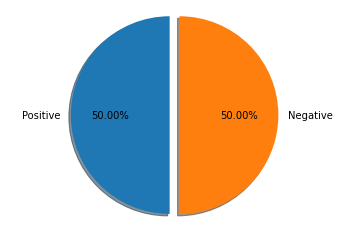

In [4]:
def class_div(data):
    data_orig['sentiment'] = data
    if process_records == False:
        pos = 1
        neg = 0

    else:
        pos = 'positive'
        neg = 'negative'


    total_counts = data_orig['sentiment'].value_counts().to_dict()
    print(total_counts)

    pos_percent = round((total_counts[pos]/data_orig.shape[0])*100,2)
    neg_percent = round((total_counts[neg]/data_orig.shape[0])*100,2)

    labels = 'Positive', 'Negative'
    sizes = [pos_percent,neg_percent]
    explode = (0.1, 0) 
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  

    plt.show()
    
    return

class_div(data_orig['sentiment'])

let's review a sample.

In [5]:
data_orig['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [6]:
data_orig['sentiment'].iloc[0]

'positive'

As we can see in the review text sample there are HTML tags, special characters, Un-even textcases in-between. So, text pre-processing is performed in order to make the text look more presentable and clean as it  helps in maining the vocabulary size.

#### Text Pre-processing

The main pre-processing done here are,
1. Striping the in-between html tags
2. Getting rid of underscores and white spaces
3. Making the text look uniform by converting to lower case, which also helps in reducing vocabulary size
4. Converting the accented characters to normal characters (Example: Café -> Cafe)
5. Removing special characters and numbers
6. Stop word removal as it does not help much in our analysis
7. Lemmatizing in-order to obtain lemma from the text (Example: Mice -> Mouse)
8. Converting the the textual categories to numerical categories (Positive -> 1, Negative -> 0)

And the list does not end here, other text pre-processing can be done (Example: Spell Correction) and some of these pre-processing can also be performed using sklearn, textblob.

In [7]:

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_underscore(text):
    text = text.replace("_"," ")
    return text

def remove_white_spaces(text):
    text = " ".join(text.split())
    return text

def to_lower_case(text):
    text = text.lower()
    return text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# Removes Numbers
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def stop_word_remover(text):
    tokens = tokenizer.tokenize(text)
    filtered_sentence = []
    for token in tokens: 
        if token not in stopword_list: 
            filtered_sentence.append(token)
            
    return " ".join(filtered_sentence)

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([nltk_lemmatizer.lemmatize(token,get_wordnet_pos(token)) for token in tokens])
    return lemmatized_output

def pre_process(text):
    text = strip_html_tags(text)
    text = remove_underscore(text)
    text = remove_white_spaces(text)
    text = to_lower_case(text)
    text = remove_accented_chars(text)
    text = remove_special_characters(text, remove_digits=True)
    text = stop_word_remover(text)
    text = lemmatize_text(text)
    return text

def start_pre_process():
    data_proc = data_orig
    if process_records == True:
        for i in tqdm(range(len(data_orig['review']))):
            data_proc['review'].iloc[i] = pre_process(data_orig['review'].iloc[i])
            if data_orig['sentiment'].iloc[i] == 'positive':
                data_proc['sentiment'].iloc[i] = 1
            else:
                data_proc['sentiment'].iloc[i] = 0   

        data_proc.to_csv('processed.csv')
    return data_proc

data_proc = start_pre_process()
process_records = False

100%|██████████| 50000/50000 [19:14<00:00, 43.30it/s]


After pre-processing. The samples looks like this,

In [8]:
data_proc['review'].iloc[0]

'one reviewer mention watch oz episode youll hooked right exactly happen methe first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull no punch regard drug sex violence hardcore classic use wordit call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show wouldnt dare forget pretty picture paint mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watch developed taste oz get accustom high level graphic violence not violence injustice crooked guard wholl sell nickel inmate wholl kill order get away well mannered middle class inmate turn prison bitch 

In [9]:
data_proc['sentiment'].iloc[0]

1

Train set class division
{0.0: 20039, 1.0: 19961}


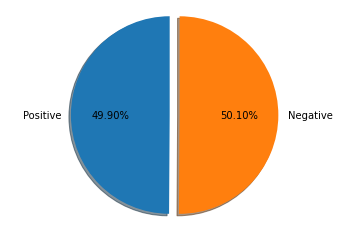

In [10]:
def split_data():
    data_proc['sentiment']=data_proc['sentiment'].astype('int')
    X_train,X_test,y_train,y_test = train_test_split(data_proc['review'],data_proc['sentiment'] ,random_state=42,test_size=0.2)
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = split_data()

print("Train set class division")
class_div(y_train)

Let's see which are the most repeated words in the corpus

In [11]:

corpus = X_train
vec = CountVectorizer().fit(corpus)
bag_of_words = vec.transform(corpus)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:10]


[('movie', 79096),
 ('film', 73614),
 ('not', 49439),
 ('one', 42232),
 ('make', 35221),
 ('like', 34321),
 ('see', 32672),
 ('get', 27788),
 ('well', 23784),
 ('time', 23565)]

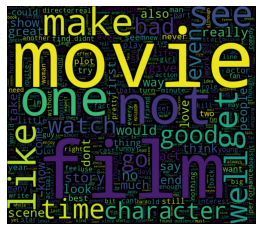

In [12]:
w = WordCloud(width=800,height=700,mode='RGBA',background_color='black',max_words=2000).fit_words(dict(words_freq))
plt.imshow(w)
plt.axis("off")
plt.show()

The next step in the process is to convert the textual data to vectorized numerical format. So we can train a model. 

To achieve this I will use Word Embeddings learned using Word2Vec.








#### Word Embeddings


<blockquote> A word embedding is a learned representation for text where words that have the same meaning have a similar representation. Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning. 
    
\- Jason Brownlee ([What Are Word Embeddings for Text?](https://machinelearningmastery.com/what-are-word-embeddings/))

</blockquote>

Word2Vec is an algorithm which is used to learn word embeddings. 



There are 2 learning methods in Word2Vec,
<ul>
    <li> Continuous Bag of words (CBOW) </li>
    <li> Skip-gram </li>
</ul>

Here in Word2Vec approach, I will train a Word2Vec model using CBOW method on the IMDB dataset and also use the pretrained Word2Vec model from Google, trained on Google News. I will analyse the performance of the classifiers based on Word2Vec trained on IMDB dataset and Pre-trained Word2Vec 

Later, I will encode the features by the below 2 methods in order to train the classifier,
<ul>
    <li> Computing the mean of embeddings in a sentence </li>
    <li> Computing TF-IDF of embeddings in a sentence </li>
    
</ul>

TF-IDF tells us how important the word is in the particular document.


The Formula for TF-IDF is,

$$ Term\;Frequency\;(TF) = \frac{ Number\;of\;times\;particular\;word\;(W)\;appeared\;in\;the\;document}{Total\;Number\;words\;in\;that\;document} $$ <br />

$$ Inverse\;Document\;Frequency\;(IDF)\;=  \log{\frac{Number\;of\;documents\;in\;corpus}{Number\;of\;documents\;in\;which\;the\;particular\;word\;(W)\;appeared}}$$ <br />

$$ TFIDF\;=TF * IDF $$



In further section, I will show the difference between mean and tf-idf methods of feature encoding based on Word2Vec vocabulary.


#### Word2Vec model trained on IMDB dataset using CBOW



In [13]:
def train_w2v():
    data_proc_w2v = []
    for i in tqdm(range (0,len(X_train))):
        data_proc_w2v.append(gensim.utils.simple_preprocess(X_train.iloc[i]))
    print("Training Word2Vec model ..")
    model = gensim.models.Word2Vec (data_proc_w2v, size=300, window=10, min_count=2, workers=10)
    model.train(data_proc_w2v,total_examples=len(data_proc_w2v),epochs=100)
    w2v_vocab = model.wv.vocab
    #model.save("word2vec.model")
    return data_proc_w2v,model,w2v_vocab



In [14]:
data_proc_w2v,model,w2v_vocab = train_w2v()



100%|██████████| 40000/40000 [00:09<00:00, 4228.68it/s]


Training Word2Vec model ..


Let's see the vocabulary generated using Word2Vec

In [15]:
w2v_vocab

{'thats': <gensim.models.keyedvectors.Vocab at 0x13e9bec50>,
 'kept': <gensim.models.keyedvectors.Vocab at 0x11e672290>,
 'ask': <gensim.models.keyedvectors.Vocab at 0x13ec6a3d0>,
 'many': <gensim.models.keyedvectors.Vocab at 0x13ec6a450>,
 'fight': <gensim.models.keyedvectors.Vocab at 0x11da07690>,
 'scream': <gensim.models.keyedvectors.Vocab at 0x11da072d0>,
 'match': <gensim.models.keyedvectors.Vocab at 0x13ef52510>,
 'swear': <gensim.models.keyedvectors.Vocab at 0x13ef52390>,
 'general': <gensim.models.keyedvectors.Vocab at 0x13ec6a5d0>,
 'mayhem': <gensim.models.keyedvectors.Vocab at 0x11da077d0>,
 'permeate': <gensim.models.keyedvectors.Vocab at 0x13ef52450>,
 'minute': <gensim.models.keyedvectors.Vocab at 0x13ef52490>,
 'comparison': <gensim.models.keyedvectors.Vocab at 0x13ef524d0>,
 'also': <gensim.models.keyedvectors.Vocab at 0x13ef52550>,
 'stand': <gensim.models.keyedvectors.Vocab at 0x13ef52590>,
 'think': <gensim.models.keyedvectors.Vocab at 0x13ef52610>,
 'onedimensional

#### Using Pre-trained Word2Vec model



In [16]:
pre_trained_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True)

#### Feature encoding based on Word2Vec vocabulary

<ul>
    <li> Mean </li>
    <li> TF-IDF </li>
</ul>



In [17]:
# The code to encode the features using Word2Vec is reused and modified.

class MeanEmbeddingVectorizer(object):

    def __init__(self, word_model,pre_trained):
        self.pre_trained = pre_trained
        self.word_model = word_model
        if self.pre_trained == False:
            self.vector_size = word_model.wv.vector_size
        else:
            self.vector_size = word_model.vector_size

    def fit(self):  # comply with scikit-learn transformer requirement
        return self

    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector

    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.


        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """
        mean = []
        for word in sent:
            if self.pre_trained == False:
                if word in self.word_model.wv.vocab:
                    mean.append(self.word_model.wv.get_vector(word))
            else:
                if word in self.word_model.vocab:
                    mean.append(self.word_model.get_vector(word))
        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            #logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.

        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [18]:
class TfidfEmbeddingVectorizer(object):

    def __init__(self, word_model,pre_trained):
        self.pre_trained = pre_trained
        self.word_model = word_model
        self.word_idf_weight = None
        if self.pre_trained == False:
            self.vector_size = word_model.wv.vector_size
        else:
            self.vector_size = word_model.vector_size



    def fit(self, docs):  # comply with scikit-learn transformer requirement
        """
        Fit in a list of docs, which had been preprocessed and tokenized,
        such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.

        Then build up a tfidf model to compute each word's idf as its weight.
        Noted that tf weight is already involved when constructing average word vectors, and thus omitted.

        :param
            pre_processed_docs: list of docs, which are tokenized
        :return:
            self
        """

        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))

        tfidf = TfidfVectorizer()
        tfidf.fit(text_docs)  # must be list of text string

        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)  # used as default value for defaultdict
        self.word_idf_weight = defaultdict(lambda: max_idf,[(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self


    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector


    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.


        :param sent: list of sentence tokens
        :return:
        mean: float of averaging word vectors
        """

        mean = []
        for word in sent:
            if self.pre_trained == False:
                if word in self.word_model.wv.vocab:
                    mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted
            else:
                if word in self.word_model.vocab:
                    mean.append(self.word_model.get_vector(word) * self.word_idf_weight[word])  # idf weighted



        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            #logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.

        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

#### Model training and plots



I will be using below classifiers for the analysis,
<ul>
    <li> Logistic Regression </li>
    <li> SVM </li>
 </ul>
 
 

In [19]:
model_params = {
    'svm': {
        'model': SVC(probability=True,verbose=1),
        'params' : {
            'C': [1,10],
            'kernel': ['rbf']
        }  
    },
    'logistic_regression' : {
        'model': LogisticRegression(max_iter=1000,verbose=1),
        'params': {
            'C': [1,10],
        }
    }
}

# Due to time and resource constraints I am using fewer number of hyper-parameters for the tuning 

In [20]:
scoring = 'f1'
folds = KFold(n_splits=5,shuffle=True,random_state=42)

In [21]:
def get_X(vocab_type):   
    if vocab_type == "mean_w2v":
        mean_vec_tr = MeanEmbeddingVectorizer(model,pre_trained = False)
        X = mean_vec_tr.transform(data_proc_w2v)
        return X
 
        
    elif vocab_type == "tfidf_w2v":
        tfidf_vec_tr = TfidfEmbeddingVectorizer(model,pre_trained = False)
        tfidf_vec_tr.fit(data_proc_w2v)  # fit tfidf model first
        X = tfidf_vec_tr.transform(data_proc_w2v)
        return X
        
    elif vocab_type == "pre_mean_w2v":        
        pre_mean_vec_tr = MeanEmbeddingVectorizer(pre_trained_model,pre_trained = True)
        X = pre_mean_vec_tr.transform(data_proc_w2v)
        return X

        
    elif vocab_type == "pre_tfidf_w2v":
        pre_tfidf_vec_tr = TfidfEmbeddingVectorizer(pre_trained_model,pre_trained = True)
        pre_tfidf_vec_tr.fit(data_proc_w2v)  # fit tfidf model first
        X = pre_tfidf_vec_tr.transform(data_proc_w2v)
        return X
    
    else:
        print("Invalid")
    
    return
        
   

In [22]:
def fit(X,y,model_params,scoring,folds):
    scores = []
    for model_name, mp in model_params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], return_train_score=False,scoring=scoring,cv=folds)
        clf.fit(X, y)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_,
            'best_estimator':clf.best_estimator_
        })
    df = pd.DataFrame(scores,columns=['model','best_score','best_params','best_estimator'])
    best_score = max(df['best_score'])
    best_clf = df['best_estimator'][df['best_score'].argmax()]
    return best_clf,df
    
    

In [23]:
# Mean of vector representation
def fit_mean_w2v():
    X  = get_X("mean_w2v")
    print("Train data shape(Mean W2V): ",X.shape)
    clf_mean_w2v, df_mean_w2v= fit(X,y_train,model_params,scoring,folds)
    mean_w2v_clf_name = df_mean_w2v['model'][df_mean_w2v['best_score'].argmax()]
    return X,clf_mean_w2v, df_mean_w2v,mean_w2v_clf_name



In [24]:
X,clf_mean_w2v, df_mean_w2v,mean_w2v_clf_name = fit_mean_w2v()

Train data shape(Mean W2V):  (40000, 300)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [25]:
df_mean_w2v

,model,best_score,best_params,best_estimator
0,svm,0.889880,"{'C': 1, 'kernel': 'rbf'}","SVC(C=1, probability=True, verbose=1)"
1,logistic_regression,0.883095,{'C': 1},"LogisticRegression(C=1, max_iter=1000, verbose=1)"


In [26]:
# TF-IDF of vector representation
def fit_tfidf_w2v():
    X  = get_X("tfidf_w2v")
    print("Train data shape(TFIDF W2V): ",X.shape)
    clf_tfidf_w2v, df_tfidf_w2v = fit(X,y_train,model_params,scoring,folds)
    tfidf_w2v_clf_name = df_tfidf_w2v['model'][df_tfidf_w2v['best_score'].argmax()]
    return X,clf_tfidf_w2v, df_tfidf_w2v,tfidf_w2v_clf_name 



In [27]:
X,clf_tfidf_w2v, df_tfidf_w2v,tfidf_w2v_clf_name  = fit_tfidf_w2v()

Train data shape(TFIDF W2V):  (40000, 300)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [28]:
 # Pre-trained Mean of vector representation
def fit_pre_mean_w2v():
    X  = get_X("pre_mean_w2v")
    print("Train data shape(Pre-trained Mean W2V): ",X.shape)
    clf_pre_mean_w2v, df_pre_mean_w2v = fit(X,y_train,model_params,scoring,folds)
    pre_mean_w2v_clf_name = df_pre_mean_w2v['model'][df_pre_mean_w2v['best_score'].argmax()]
    return X,clf_pre_mean_w2v, df_pre_mean_w2v,pre_mean_w2v_clf_name



In [29]:
X,clf_pre_mean_w2v, df_pre_mean_w2v,pre_mean_w2v_clf_name = fit_pre_mean_w2v()



Train data shape(Pre-trained Mean W2V):  (40000, 300)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [30]:
# Pre-trained TF-IDF of vector representation
def fit_pre_tfidf_w2v():
    X  = get_X("pre_tfidf_w2v")
    print("Train data shape(Pre-trained TFIDF W2V): ",X.shape)
    clf_pre_tfidf_w2v, df_pre_tfidf_w2v = fit(X,y_train,model_params,scoring,folds)
    pre_tfidf_w2v_clf_name = df_pre_tfidf_w2v['model'][df_pre_tfidf_w2v['best_score'].argmax()]
    return X,clf_pre_tfidf_w2v, df_pre_tfidf_w2v,pre_tfidf_w2v_clf_name



In [31]:
X,clf_pre_tfidf_w2v, df_pre_tfidf_w2v,pre_tfidf_w2v_clf_name = fit_pre_tfidf_w2v()

Train data shape(Pre-trained TFIDF W2V):  (40000, 300)
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

#### The Best models comparison

Making a common ground for testing on X_test.

In [118]:
def generate_comparison(w2v=True,pre_w2v=True,mean_w2v=True,tfidf_w2v=True,pre_mean_w2v=True,pre_tfidf_w2v=True):

    all_clf = dict()
    all_clf_names = dict()
    all_X_test = dict()
    auc = dict()

    r_proba = [0 for _ in range(len(X_test))]
    r_auc = roc_auc_score(y_test,r_proba)
    print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
    r_fpr, r_tpr, _ = roc_curve(y_test, r_proba)
    plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

    if w2v:
        w2v_model_vocab = model 
        w2v_test = []
        for i in tqdm(range (0,len(X_test))):
            w2v_test.append(gensim.utils.simple_preprocess(X_test.iloc[i]))
    

    if mean_w2v:
        all_clf['mean_w2v'] = clf_mean_w2v
        all_clf_names['mean_w2v'] = mean_w2v_clf_name
        w2v_mean = MeanEmbeddingVectorizer(w2v_model_vocab,pre_trained=False)
        mean_w2v_test = w2v_mean.transform(w2v_test)
        all_X_test['mean_w2v'] = mean_w2v_test
        mean_w2v_proba = clf_mean_w2v.predict_proba(mean_w2v_test)
        mean_w2v_proba = mean_w2v_proba[:, 1]
        mean_w2v_auc = roc_auc_score(y_test,mean_w2v_proba)
        print('Mean W2V: AUROC = %.3f' % (mean_w2v_auc))
        mean_w2v_fpr, mean_w2v_tpr, _ = roc_curve(y_test, mean_w2v_proba)
        plt.plot(mean_w2v_fpr, mean_w2v_tpr, marker='.', label='Mean W2V (AUROC = %0.3f)' % mean_w2v_auc)
        auc['mean_w2v'] = mean_w2v_auc
        
        
    if tfidf_w2v:       
        all_clf['tfidf_w2v'] = clf_tfidf_w2v
        all_clf_names['tfidf_w2v'] = tfidf_w2v_clf_name        
        w2v_tfid = TfidfEmbeddingVectorizer(w2v_model_vocab,pre_trained=False)
        w2v_tfid.fit(w2v_test)
        tfid_w2v_test = w2v_tfid.transform(w2v_test)
        all_X_test['tfidf_w2v'] = tfid_w2v_test
        tfidf_w2v_proba = clf_tfidf_w2v.predict_proba(tfid_w2v_test)
        tfidf_w2v_proba = tfidf_w2v_proba[:, 1]
        tfidf_w2v_auc = roc_auc_score(y_test,tfidf_w2v_proba)
        print('Tfidf W2V: AUROC = %.3f' % (tfidf_w2v_auc))
        tfidf_w2v_fpr,tfidf_w2v_tpr, _ = roc_curve(y_test,tfidf_w2v_proba)
        plt.plot(tfidf_w2v_fpr, tfidf_w2v_tpr, marker='.', label='Tfidf W2V (AUROC = %0.3f)' % tfidf_w2v_auc)
        auc['tfidf_w2v'] = tfidf_w2v_auc
        
    if pre_w2v:
        #pre_trained_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True)
        w2v_test = []
        for i in tqdm(range (0,len(X_test))):
            w2v_test.append(gensim.utils.simple_preprocess(X_test.iloc[i]))
        
    if pre_mean_w2v:
        all_clf['pre_trained_mean_w2v'] = clf_pre_mean_w2v
        all_clf_names['pre_trained_mean_w2v'] = pre_mean_w2v_clf_name
        pre_w2v_mean = MeanEmbeddingVectorizer(pre_trained_model,pre_trained=True)
        pre_mean_w2v_test = pre_w2v_mean.transform(w2v_test)
        all_X_test['pre_trained_mean_w2v'] = pre_mean_w2v_test
        pre_mean_w2v_proba = clf_pre_mean_w2v.predict_proba(pre_mean_w2v_test)
        pre_mean_w2v_proba = pre_mean_w2v_proba[:, 1]
        pre_mean_w2v_auc = roc_auc_score(y_test,pre_mean_w2v_proba)
        print('Pre-Mean W2V: AUROC = %.3f' % (pre_mean_w2v_auc))
        pre_mean_w2v_fpr, pre_mean_w2v_tpr, _ = roc_curve(y_test, pre_mean_w2v_proba)
        plt.plot(pre_mean_w2v_fpr, pre_mean_w2v_tpr, marker='.', label='Pre-Mean W2V (AUROC = %0.3f)' % pre_mean_w2v_auc)
        auc['pre_trained_mean_w2v'] = pre_mean_w2v_auc

    if pre_tfidf_w2v:
        all_clf['pre_trained_tfidf_w2v']= clf_pre_tfidf_w2v
        all_clf_names['pre_trained_tfidf_w2v'] =pre_tfidf_w2v_clf_name
        pre_w2v_tfid = TfidfEmbeddingVectorizer(pre_trained_model,pre_trained=True)
        pre_w2v_tfid.fit(w2v_test)
        pre_tfid_w2v_test = pre_w2v_tfid.transform(w2v_test)
        all_X_test['pre_trained_tfidf_w2v'] = pre_tfid_w2v_test
        pre_tfidf_w2v_proba = clf_pre_tfidf_w2v.predict_proba(pre_tfid_w2v_test)
        pre_tfidf_w2v_proba = pre_tfidf_w2v_proba[:, 1]
        pre_tfidf_w2v_auc = roc_auc_score(y_test,pre_tfidf_w2v_proba)
        print('Pre-Tfidf W2V: AUROC = %.3f' % (pre_tfidf_w2v_auc))
        pre_tfidf_w2v_fpr,pre_tfidf_w2v_tpr, _ = roc_curve(y_test,pre_tfidf_w2v_proba)
        plt.plot(pre_tfidf_w2v_fpr, pre_tfidf_w2v_tpr, marker='.', label='Pre-Tfidf W2V (AUROC = %0.3f)' % pre_tfidf_w2v_auc)
        auc['pre_trained_tfidf_w2v'] = pre_tfidf_w2v_auc
    
    # Title
    plt.title('ROC Plot for classifiers trained on dataset of size '+ str(len(X_train)))
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()


    best_clf_vocab = max(auc, key=auc.get)
    best_clf = all_clf[best_clf_vocab]
    print("The best performing classifier is" ,all_clf_names[best_clf_vocab]," on the ",best_clf_vocab," vocabulary")
    y_pred = best_clf.predict(all_X_test[best_clf_vocab])
    print("Accuracy is ",accuracy_score(y_test, y_pred))
    plot_confusion_matrix(best_clf, all_X_test[best_clf_vocab], y_test)
    plt.show()
    print(classification_report(y_test, y_pred, target_names=['0','1']))


    least_clf_vocab = min(auc, key=auc.get)
    least_clf = all_clf[least_clf_vocab]
    print("The least performing classifier is" ,all_clf_names[least_clf_vocab]," on the",least_clf_vocab,"vocabulary")
    y_pred = least_clf.predict(all_X_test[least_clf_vocab])
    print("Accuracy is ",accuracy_score(y_test, y_pred))
    plot_confusion_matrix(least_clf, all_X_test[least_clf_vocab], y_test)
    plt.show()
    print(classification_report(y_test, y_pred, target_names=['0','1']))

    save_model = "best_model_" + all_clf_names[best_clf_vocab]+".sav"
    pickle.dump(best_clf, open(save_model, 'wb'))
    print("Best model is saved to the disk as ",save_model)

    if best_clf_vocab == "mean_w2v" or best_clf_vocab == "tfidf_w2v":
        model.save("word2vec.model")
        print("The best clf vocabulary is saved as word2vec.model")
    else:
        print("The pre-trained w2v model is already on the disk.")
    
    return best_clf_vocab,save_model

  5%|▌         | 538/10000 [00:00<00:01, 5379.99it/s]

Random (chance) Prediction: AUROC = 0.500


100%|██████████| 10000/10000 [00:01<00:00, 5860.85it/s]


Mean W2V: AUROC = 0.957


  6%|▋         | 650/10000 [00:00<00:01, 6479.48it/s]

Tfidf W2V: AUROC = 0.956


100%|██████████| 10000/10000 [00:01<00:00, 6030.47it/s]


Pre-Mean W2V: AUROC = 0.940
Pre-Tfidf W2V: AUROC = 0.930


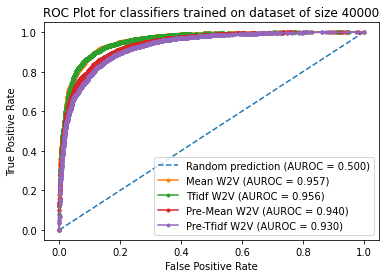

The best performing classifier is svm  on the  mean_w2v  vocabulary
Accuracy is  0.89


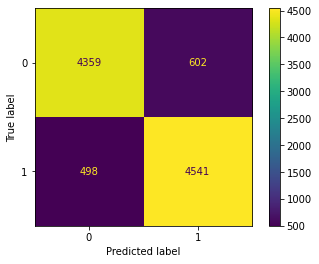

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

The least performing classifier is svm  on the pre_trained_tfidf_w2v vocabulary
Accuracy is  0.8501


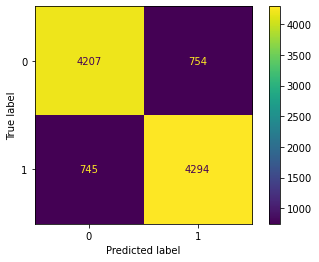

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Best model is saved to the disk as  best_model_svm.sav
The best clf vocabulary is saved as word2vec.model


In [132]:
vocab_name, clf_name = generate_comparison()

#### Testing sentiment with random movie review

Type any random review and test



In [137]:
clf = pickle.load(open(clf_name, 'rb'))

if vocab_name == "mean_w2v" or vocab_name == "pre_trained_mean_w2v":
    if vocab_name == "mean_w2v":
        vocab = Word2Vec.load("word2vec.model")
        w2v_mean =MeanEmbeddingVectorizer(vocab,pre_trained=False)

    else:
        pre_trained_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True)   
        w2v_mean = MeanEmbeddingVectorizer(pre_trained_model,pre_trained=True)

elif vocab_name == "tfidf_w2v" or vocab_name == "pre_trained_tfidf_w2v":
    if vocab_name == "tfidf_w2v":
        vocab = Word2Vec.load("word2vec.model")
        w2v_tfid = TfidfEmbeddingVectorizer(vocab,pre_trained=False)
    else:
        pre_trained_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True)   
        w2v_tfid = TfidfEmbeddingVectorizer(pre_trained_model,pre_trained=True)

else:
    print("Invalid Input")
        
    

In [138]:
def get_rl_test_pred(processed_sentence):
    if vocab_name == "mean_w2v" or vocab_name == "pre_trained_mean_w2v":
        rl_test_x = []
        rl_test_x.append(gensim.utils.simple_preprocess(processed_sentence))


        rl_test_x = w2v_mean.transform(rl_test_x)
        y_pred = clf.predict(rl_test_x)

    elif vocab_name == "tfidf_w2v" or vocab_name == "pre_trained_tfidf_w2v":

        rl_test_x = gensim.utils.simple_preprocess(processed_sentence)
        w2v_tfid.fit([rl_test_x])
        rl_test_x = w2v_tfid.transform([rl_test_x])
        y_pred = clf.predict(rl_test_x)


    else:
        print("Invalid Input")


    if y_pred == 1:
        print("It is a Positive Sentiment")

    if y_pred == 0:
        print("It is a Negative Sentiment")
        
    return

In [153]:
sentence = "I love the Iron Man movie"
processed_sentence = pre_process(sentence)
get_rl_test_pred(processed_sentence)

It is a Positive Sentiment


In [156]:
sentence = "This movie is one of the awful movie ever!!!"
processed_sentence = pre_process(sentence)
get_rl_test_pred(processed_sentence)

It is a Negative Sentiment


#### Conclusion

The SVM classifier performed best on the word embeddings trained using Word2Vec on IMDB dataset using Mean scoring and there is no much difference w.r.t the scoring compared to TF-IDF. And as we can see in the ROC plot, that the AUROC for model trained on word embeddings with mean scoring is greater compared to other models.

The model was trained with f1 scoring as a performance measure by giving equal importance to both the classes. Hence the obtained f1 score for both the classes is 0.89 and accuracy is also 0.89.

Bag of words(BOW)  approach can also be used in generating the vocabulary, but the size of vocabulary and time for training grows larger when the dataset is large and also when using n-grams method with n > 1. We can use TF-IDF scoring for feature extraction with BOW approach, but using this method with BOW results in sparse values for large number of features. So, using word embeddings is good option.


The performance of the model can be increased a bit more with proper hyper parameter tuning and also using word embeddings with deep learning approach will yield a good performing model.


 **The model trained using this dataset is deployed in a web app, which is developed using flask. 
 Check out the sentiment analysis web app [here.](https://analyze-sentiments.herokuapp.com)**

### References and Acknowledgements (**A Big Thank You** )

* [Dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

* [A General Approach to Preprocessing Text Data](https://www.kdnuggets.com/2017/12/general-approach-preprocessing-text-data.html)

* [NLP Text Preprocessing: A Practical Guide and Template](https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79)

* [Text Wrangling & Pre-processing: A Practitioner’s Guide to NLP](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html)

* [Text Classification with Python and Scikit-Learn](https://stackabuse.com/text-classification-with-python-and-scikit-learn/)

* [Lemmatization Approaches with Examples in Python](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)

* [Building a wordcloud using a TD-IDF vectorizer on twitter data](https://hampao.wordpress.com/2016/04/08/building-a-wordcloud-using-a-td-idf-vectorizer-on-twitter-data/)

* [How to list the most common words from text corpus using Scikit-Learn?](https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d)

* [A Gentle Introduction to the Bag-of-Words Model](https://machinelearningmastery.com/gentle-introduction-bag-words-model/)

* [What Are Word Embeddings for Text?](https://machinelearningmastery.com/what-are-word-embeddings/)

* [How to Develop Word Embeddings in Python with Gensim](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

* [Text Classification With Word2Vec](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/)

* [Gensim Word2Vec Tutorial – Full Working Example](https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XuvyOi-w3OR)

* [Word2Vec with Gensim - Python](https://www.youtube.com/watch?v=Z1VsHYcNXDI&t=362s)

* [Machine Learning in Python: Making Receiver Operating Characteristic (ROC) curve](https://github.com/dataprofessor/code/blob/master/python/ROC_curve.ipynb)

* [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

* [Finding best model and hyper parameter tunning using GridSearchCV](https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb)

There is always a room for improvements and any constructive criticism is much appreciated.